In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [2]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from utils import *
import seaborn as sns
sns.set_palette("muted")
sns.set_style("whitegrid")

## weight decay

- 方式1
``` python
new_weight = weight - lr * weight.grad - lr * wd * weight
```
- 方式2
``` python
weight = weight - lr*(weight.grad + wd*weight)
```

方式1更准确一些，方式2更改了梯度

- python 是面向对象语言，可以为Python的函数设置属性，通过 `__dict__` 访问

In [3]:
def f(x):
    return x ** 3

In [4]:
f.default = 6

In [5]:
f.__dict__

{'default': 6}

In [6]:
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p
weight_decay._defaults = dict(wd=0.)

def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

## 动量实验

In [7]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5, 0.7, 0.9, 0.99]

In [8]:
def plot_mom(f):
    _, axs = plt.subplots(2,2, figsize=(12,8))
    for beta,ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg,res = None,[]
        for i,yi in enumerate(y):
            avg,p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res)
        ax.set_title(f'beta={beta}')

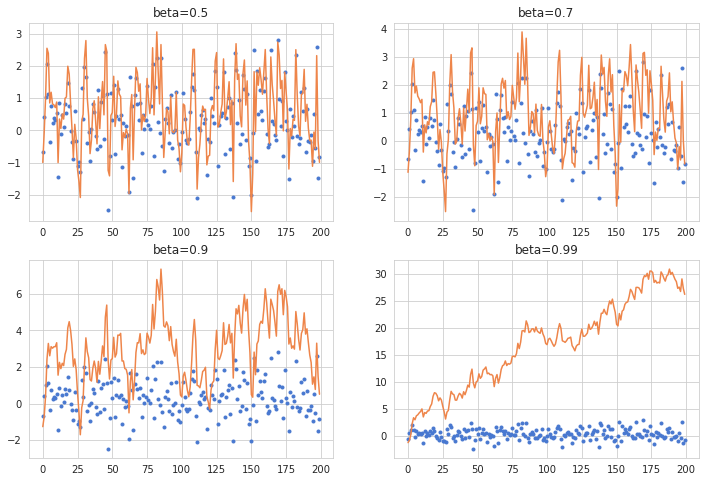

In [9]:
def mom1(avg, beta, yi, i): 
    if avg is None: avg=yi
    res = beta*avg + yi  # 更新公式
    return res,res
plot_mom(mom1)

平滑噪声数据的另一种方法是进行指数加权移动平均(ewma)。 在这种情况下，新值前面有一个（1-beta）的衰减。

### 指数平均

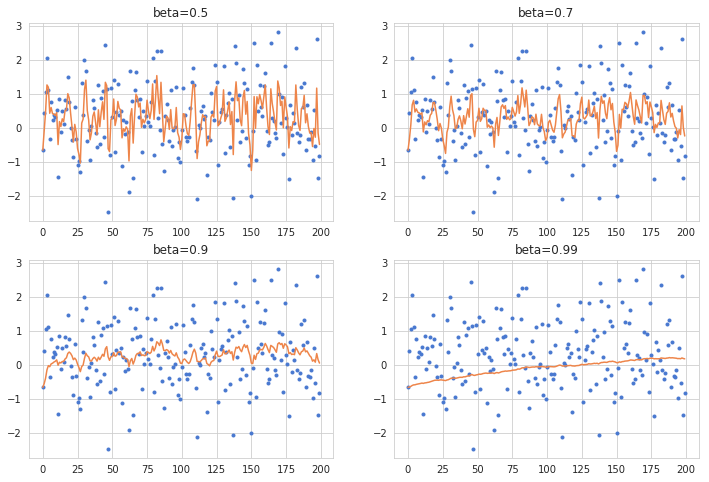

In [10]:
def mom3(avg, beta, yi, i): 
    if avg is None: avg=yi
    res = beta*avg + yi * (1 - beta)  # 更新公式
    return res,res
plot_mom(mom3)

In [11]:
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

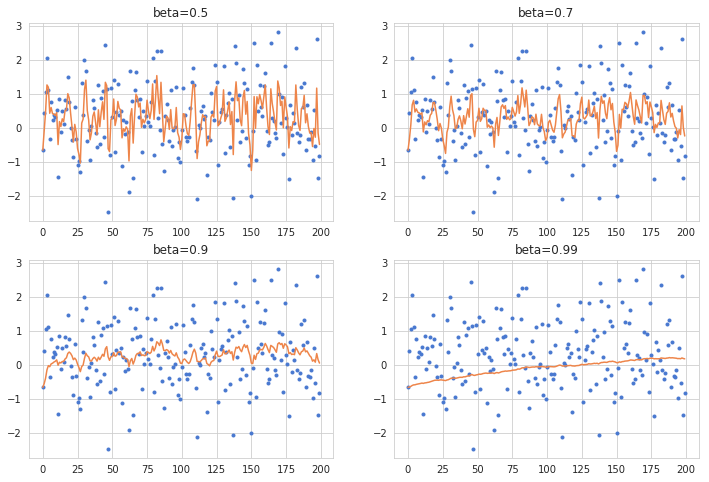

In [12]:
def mom2(avg, beta, yi, i):
    if avg is None: avg=yi
    avg = lin_comb(avg, yi, beta)
    return avg, avg
plot_mom(mom2)

如果数据具有某种形状，它将获得该形状（对于高beta有一些延迟）。

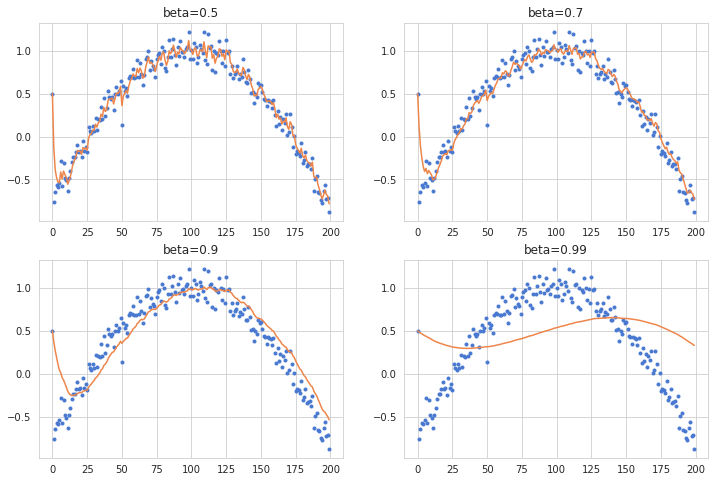

In [13]:
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1
y[0] = 0.5
plot_mom(mom2)

滑动平均

$\begin{align*}
avg_{i} &= \beta\ avg_{i-1} + (1-\beta)\ v_{i} = \beta\ (\beta\ avg_{i-2} + (1-\beta)\ v_{i-1}) + (1-\beta)\ v_{i} \\
&= \beta^{2}\ avg_{i-2} + (1-\beta)\ \beta\ v_{i-1} + (1-\beta)\ v_{i} \\
&= \beta^{3}\ avg_{i-3} + (1-\beta)\ \beta^{2}\ v_{i-2} + (1-\beta)\ \beta\ v_{i-1} + (1-\beta)\ v_{i} \\
&\vdots \\
&= (1-\beta)\ \beta^{i}\ v_{0} + (1-\beta)\ \beta^{i-1}\ v_{1} + \cdots + (1-\beta)\ \beta^{2}\ v_{i-2} + (1-\beta)\ \beta\  v_{i-1} + (1-\beta)\ v_{i}
\end{align*}$

系数的和

$\begin{align*}
S &=(1-\beta)\ \beta^{i} + (1-\beta)\ \beta^{i-1} + \cdots + (1-\beta)\ \beta^{2} + (1-\beta)\ \beta + (1-\beta) \\
&= (\beta^{i} - \beta^{i+1}) + (\beta^{i-1} - \beta^{i}) + \cdots + (\beta^{2} - \beta^{3}) + (\beta - \beta^{2}) + (1-\beta) \\
&= 1 - \beta^{i+1}
\end{align*}$


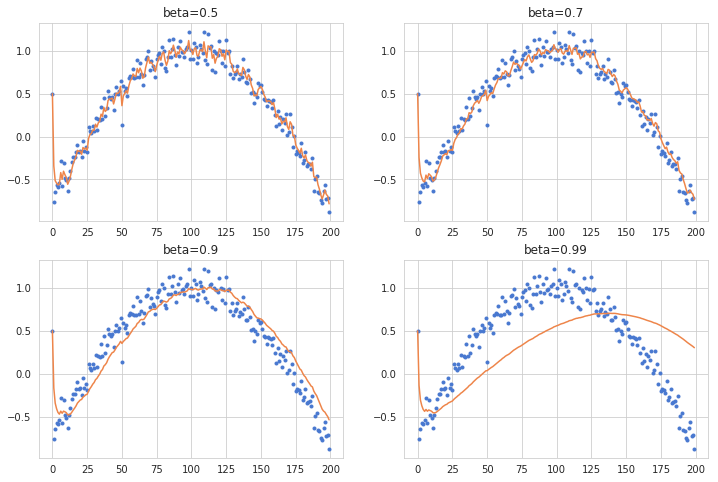

In [14]:
def mom4(avg, beta, yi, i):
    if avg is None: avg=0
    avg = lin_comb(avg, yi, beta)
    return avg, avg/(1-beta**(i+1))
plot_mom(mom4)

In [15]:
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + wd*p.data
    r2 = step.pow(2).mean().sqrt()
    p.data.add_(-lr * min(r1/r2,10), step)
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)